# Importing modules

In [1]:
import numpy as np
from keras import models, layers, optimizers, metrics, losses, regularizers
import img_util as util
from scipy import io as sio
import os
from matplotlib import pyplot as plt

Using TensorFlow backend.


# Loading Datasets

In [2]:
def loadPaviaUData():
    data_path = os.path.join('F:\main_project\Datasets')
    data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
    labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [3]:
data_set, gt=loadPaviaUData()

# Splitting the dataset

In [4]:
train_fraction = 0.85
rem_classes = [0]
(train_rows, train_cols), (test_rows, test_cols) = util.data_split(gt,
                                                                   train_fraction=train_fraction,
                                                                   rem_classes=rem_classes)

print('Number of training samples = {}.\nNumber of test samples = {}.'.format(len(train_rows), len(test_rows)))

Number of training samples = 36354.
Number of test samples = 6420.


A portion of training data can optionally be set aside for validation.

In [5]:
val_fraction = 0.05
(train_rows_sub, train_cols_sub), (val_rows, val_cols) = util.val_split(
        train_rows, train_cols, gt , val_fraction=val_fraction)

In [6]:
data_set= util.reduce_dim(img_data=data_set, n_components=75)
data_set.shape

(610, 340, 75)

# Creating input for MLP

In [7]:
patch_size=1
train_pixel_indices_sub = (train_rows_sub, train_cols_sub)
val_pixel_indices = (val_rows, val_cols)
test_pixel_indices = (test_rows, test_cols) 
catg_labels = np.unique([int(gt[idx[0],idx[1]]) for idx in zip(train_rows, train_cols)])
int_to_vector_dict = util.label_2_one_hot(catg_labels) 

train_input_sub, y_train_sub = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=train_pixel_indices_sub,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

val_input, y_val = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=val_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

test_input, y_test = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=test_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

# Creating an MLP neural network

In [8]:
units_1 = 2**8
drop_rate =0.35
num_catg = len(catg_labels)
input_shape = (patch_size, patch_size, data_set.shape[-1])

# Building a MLP network model
nn_model = models.Sequential()
#
# dense_input
nn_model.add(layer=layers.Dense(units=data_set.shape[2], activation='relu',
                                input_shape=input_shape))
# flatten_1, changes input shape from (1,1,num_band) to (num_band,)
nn_model.add(layer=layers.Flatten())
# dense_1
nn_model.add(layer=layers.Dense(units=units_1, activation='relu')) 
# dropout_1
nn_model.add(layer=layers.Dropout(drop_rate))
# dense_output
nn_model.add(layer=layers.Dense(units=num_catg, activation='softmax'))

nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 1, 75)          5700      
_________________________________________________________________
flatten_1 (Flatten)          (None, 75)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               19456     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 2313      
Total params: 27,469
Trainable params: 27,469
Non-trainable params: 0
_________________________________________________________________


# Training model

In [9]:
lr = 1e-4
batch_size = 2**3

# Compiling the modele
nn_model.compile(optimizer=optimizers.RMSprop(lr=lr),
                 loss=losses.categorical_crossentropy,
                 metrics=[metrics.categorical_accuracy])

# Training the model
nn_model.fit(x=train_input_sub, y=y_train_sub, batch_size=batch_size,
                       epochs=15, validation_data=(val_input, y_val), verbose=False)

# Model performance evaluation

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import spectral
import matplotlib

In [11]:
def reports (X_test,y_test):
    Y_pred =nn_model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ['Asphalt','Meadows','Gravel','Trees','Painted metal sheets','Bare Soil','Bitumen','Sels-Blocking Bricks','Shadows']
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    avgAcc=[]
    classArray=[]
    for c in range(len(confusion)):
        recallSoc=confusion[c][c]/sum(confusion[c])
        classArray+=[recallSoc]
    avgAcc.append(sum(classArray)/len(classArray))
    avg_accuracy=np.mean(avgAcc)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    overall_loss, overall_accu = nn_model.evaluate(X_test, y_test, verbose=False)
    
    
    return classification, confusion, kappa,  overall_accu, avg_accuracy


In [12]:
classification, confusion,  kappa, overall_accuracy, avg_accuracy = reports(test_input,y_test)
print('Classification_report:\n')
print('{}\n'.format(classification))
print('Confusion_matrix :\n')
print('{}\n'.format(confusion))
print('Kappa value : {}\n'.format(kappa))
print('Overall accuracy : {}\n'.format(overall_accuracy))
print('Average_accuracy : {}\n'.format(avg_accuracy))

Classification_report:

                      precision    recall  f1-score   support

             Asphalt       0.92      0.95      0.94       995
             Meadows       0.98      0.98      0.98      2798
              Gravel       0.87      0.66      0.75       315
               Trees       0.94      0.97      0.95       460
Painted metal sheets       1.00      1.00      1.00       202
           Bare Soil       0.97      0.92      0.94       755
             Bitumen       0.91      0.77      0.83       200
Sels-Blocking Bricks       0.80      0.90      0.85       553
             Shadows       1.00      0.99      1.00       142

            accuracy                           0.94      6420
           macro avg       0.93      0.90      0.91      6420
        weighted avg       0.94      0.94      0.94      6420


Confusion_matrix :

[[ 950    2    1    0    0    1   15   26    0]
 [   0 2748    0   29    0   21    0    0    0]
 [  14    3  207    0    0    0    0   91    0]
 [

Text(0.5, 1.0, 'Classification Map of GroundTruth')

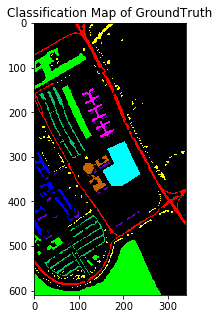

In [13]:
ground_truth = spectral.imshow(classes = gt,figsize =(5,5))
plt.title('Classification Map of GroundTruth')

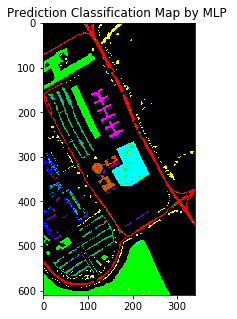

In [14]:
concat_rows =  np.concatenate((train_rows_sub, val_rows, test_rows))
concat_cols = np.concatenate((train_cols_sub, val_cols, test_cols))
concat_input = np.concatenate((train_input_sub, val_input, test_input))
concat_y = np.concatenate((y_train_sub, y_val, y_test))
pixel_indices = (concat_rows, concat_cols)

partial_map = util.plot_partial_map(nn_model, gt, pixel_indices, concat_input,
                            concat_y, int_to_vector_dict, plo=False)
full_map = util.plot_full_map(nn_model, data_set, gt, int_to_vector_dict, patch_size, plo=False)

predicted_image=spectral.imshow(classes=partial_map.astype(int),figsize =(5,5),cmap= 'jet')
plt.title('Prediction Classification Map by MLP ')
plt.show()

In [15]:
from tqdm import tqdm
import pandas as pd
def extract_pixels(dataset, ground_truth):
    df = pd.DataFrame()
    for i in tqdm(range(dataset.shape[2])):
        df = pd.concat([df, pd.DataFrame(dataset[:, :, i].ravel())], axis=1)
    df = pd.concat([df, pd.DataFrame(ground_truth.ravel())], axis=1)
    df.columns = [f'band-{i}' for i in range(1, 1+dataset.shape[2])]+['class']
    return df

In [16]:
df = extract_pixels(data_set, gt)

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:09<00:00,  7.93it/s]


In [17]:
df.to_csv('data_set.csv', index=False)

In [18]:
df = pd.read_csv('data_set.csv')

In [19]:
df.head()

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-67,band-68,band-69,band-70,band-71,band-72,band-73,band-74,band-75,class
0,-5150.190044,6795.052770,1532.351461,410.030134,-259.856157,-832.898970,293.239776,278.385213,-285.609914,251.208844,...,-3.922149,-7.570744,-6.188630,6.013479,-3.320831,-1.612457,-0.768773,-7.756281,3.163554,0
1,-6082.245760,3158.592195,1463.194744,154.617093,-438.871878,-496.202149,362.925839,187.355434,-287.796733,180.614526,...,-4.639557,-19.205404,-3.765219,-5.967894,-1.335124,5.409274,-0.961697,6.744788,3.962571,0
2,-7214.505405,1158.875812,1400.817899,410.044063,38.052916,-560.804196,-140.004203,8.847608,-211.057195,14.139042,...,10.598359,0.214651,2.392519,-11.182375,1.209667,2.211739,2.382483,11.371825,-7.459643,0
3,-6566.279360,3398.894763,1126.024772,496.775042,-302.415250,-409.493899,218.391586,-2.957277,-223.380076,188.819722,...,-14.212208,0.235794,-12.080695,1.818343,-11.526370,3.629478,6.046255,3.711914,8.199024,0
4,-6496.967970,2154.797771,1035.954575,27.247705,-194.891403,-189.044607,-71.142484,-97.987804,-126.456170,215.182030,...,0.738595,-1.802633,-6.021863,5.412263,-1.616741,4.083012,2.597510,-1.968348,-3.273925,0


In [20]:
df.tail()

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-67,band-68,band-69,band-70,band-71,band-72,band-73,band-74,band-75,class
207395,-4315.315283,208.879103,-37.600057,-15.785801,116.620060,94.731463,-24.377063,-56.796093,-24.726144,-120.221992,...,10.164137,6.465964,-6.717853,-16.878652,2.775805,-12.394278,4.678853,1.932749,-4.897677,0
207396,-4012.494488,685.248307,199.328731,55.691615,137.768056,98.122063,-20.840423,-305.353258,-69.463159,-224.923459,...,-12.019290,10.577555,-3.089345,1.982679,-3.306720,3.370099,2.608547,0.554215,-4.996003,0
207397,-3975.035084,1643.062559,253.132178,-287.686124,114.539234,212.257349,-7.753115,-106.171030,80.450729,-58.222229,...,-1.091461,3.907875,13.017766,4.570088,-2.395375,4.178624,3.372269,15.102545,-3.280732,0
207398,-4042.639452,1231.520377,499.960314,-126.281001,-153.053615,288.243257,-33.275723,-206.172221,22.918281,-174.921876,...,-14.895738,1.240332,-6.189896,2.995576,-1.768789,1.897357,11.270772,-0.271285,5.851728,0
207399,-4086.615756,2180.667628,454.933275,-44.397947,-174.822084,262.134519,-194.121328,92.641721,90.094392,-88.414057,...,22.694297,-3.097800,10.701889,-0.432715,2.223701,4.617140,-7.565883,-1.983551,-11.443359,0


In [21]:
df.count()

band-1     207400
band-2     207400
band-3     207400
band-4     207400
band-5     207400
            ...  
band-72    207400
band-73    207400
band-74    207400
band-75    207400
class      207400
Length: 76, dtype: int64

In [22]:
Dataset = df.iloc[:, :-1].values

groundTruth = df.iloc[:, -1].values

In [23]:
Dataset.shape, groundTruth.shape

((207400, 75), (207400,))

In [24]:
def plot_signature(df):
    plt.figure(figsize=(12, 6))
    pixel_no = np.random.randint(df.shape[0])
    plt.plot(range(1, 76), df.iloc[pixel_no, :-1].values.tolist(), 'b--', label= f'Class - {df.iloc[pixel_no, -1]}')
    plt.legend()
    plt.title(f'Pixel({pixel_no}) signature', fontsize=14)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    plt.show()

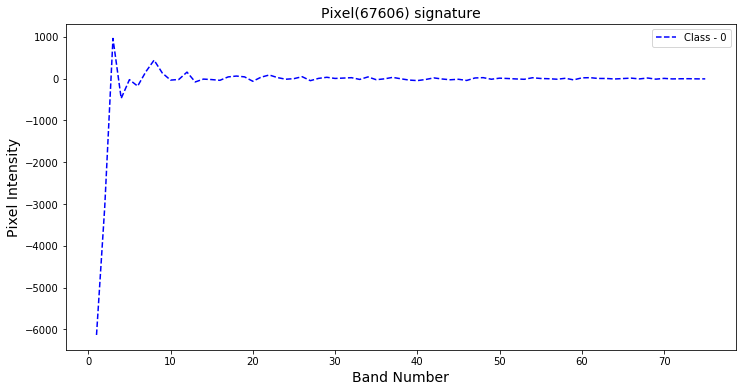

In [25]:
plot_signature(df)

In [26]:
print(f"Unique Class Labels: {df.loc[:, 'class'].unique()}")

Unique Class Labels: [0 1 4 2 8 5 9 6 3 7]


In [27]:
df.loc[:, 'class'].value_counts()

0    164624
2     18649
1      6631
6      5029
8      3682
4      3064
3      2099
5      1345
7      1330
9       947
Name: class, dtype: int64

In [28]:
df[df['class']== 9][0:2000]

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-67,band-68,band-69,band-70,band-71,band-72,band-73,band-74,band-75,class
51815,-8077.422308,-7908.034522,1478.225578,98.769441,-72.294826,36.277772,123.149317,-116.653589,-34.335056,-108.623483,...,0.831321,-3.706153,2.037348,-16.432018,1.807452,7.257595,5.277928,-4.249727,8.264665,9
51816,-8712.236992,-7353.096882,957.253416,-55.622575,-11.999892,-73.770255,13.705591,-92.570190,14.116840,123.318958,...,0.898283,-5.121513,-9.662648,3.248542,7.450821,0.167015,2.555103,-4.076542,1.755983,9
52154,-8808.581272,-7440.865776,944.953789,-3.978076,-69.846219,23.500875,-273.636846,263.862181,10.852788,-63.824943,...,2.555849,3.570028,-11.519785,4.710857,-0.095867,-4.318579,4.885472,-4.488190,0.862016,9
52155,-9008.592603,-6949.306207,832.648512,-184.118040,2.451413,-105.582147,56.162772,143.949858,128.794983,212.966845,...,-0.282223,1.848762,-9.062093,15.626785,-1.983284,-4.074917,1.198513,-3.740579,10.012979,9
52156,-8998.701651,-6535.683856,834.329378,-257.944627,57.304740,-81.222942,300.172116,9.131556,116.422073,172.784939,...,0.866295,3.513457,-1.577772,6.175230,7.559542,3.688827,-10.914354,-3.155249,-1.727160,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168040,-8829.804680,-8042.965937,718.996940,36.130748,-209.392802,-34.308674,43.921449,69.241000,12.630584,41.168776,...,12.803147,-3.947057,-14.047976,-0.940868,0.862541,-7.026580,-8.085293,-5.396196,9.170066,9
168377,-8796.215680,-8039.640688,937.555118,201.177707,-411.290246,18.795061,-78.169493,35.555916,43.595954,53.038210,...,-5.480284,-3.920406,2.444366,3.211648,-6.035865,-0.665906,-2.117051,5.942947,-4.319991,9
168378,-8677.150864,-7977.386206,845.132252,90.927523,-225.308832,-42.180991,42.092428,-29.364385,-48.563233,-81.777241,...,-8.471517,-5.401509,-4.493402,-17.917556,8.709823,1.667175,8.748279,12.513196,-3.068691,9
168379,-8507.517901,-7940.718865,786.487817,-16.214573,-141.411617,-82.440010,138.435594,-133.471954,14.915186,74.032071,...,6.332751,-10.445535,-13.194698,-9.891677,-3.506194,8.198468,1.311530,-1.416460,2.040622,9
